# Kickstarter Machine Learning Project

In [0]:
"""
From Ahmad:
I would suggest to try multiple models for classification
and regression and compare them to make your project more
significant. Also focus a bit more on the EDA part and try
to make an interesting analysis with nice visualisations.
There could be interesting questions which could be answered
by your analysis, eg: which category of the projects have a
higher success rate. Also if this data-set was already used
in a kaggle competition, you can also report and compare your
accuracy with the accuracy of the wining team of the
competition in kaggle.
"""

'\nFrom Ahmad:\nI would suggest to try multiple models for classification\nand regression and compare them to make your project more\nsignificant. Also focus a bit more on the EDA part and try\nto make an interesting analysis with nice visualisations.\nThere could be interesting questions which could be answered\nby your analysis, eg: which category of the projects have a\nhigher success rate. Also if this data-set was already used\nin a kaggle competition, you can also report and compare your\naccuracy with the accuracy of the wining team of the\ncompetition in kaggle.\n'

In [0]:
# imports
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Loading the data

In [23]:
df = pd.read_csv("https://raw.githubusercontent.com/tbacha/DMML2019_Team_Apple/master/data/ks-projects-201801.csv")
df.head(2)

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00


In [24]:
print("The dataset contains %d observations and %d features." % (df.shape[0], df.shape[1]))

The dataset contains 378661 observations and 15 features.


# Data cleaning
Applying correct data type to time features.

In [25]:
df["deadline"] = pd.to_datetime(df["deadline"])
df["launched"] = pd.to_datetime(df["launched"])
df.dtypes

ID                           int64
name                        object
category                    object
main_category               object
currency                    object
deadline            datetime64[ns]
goal                       float64
launched            datetime64[ns]
pledged                    float64
state                       object
backers                      int64
country                     object
usd pledged                float64
usd_pledged_real           float64
usd_goal_real              float64
dtype: object

In [26]:
df["state"].unique()

array(['failed', 'canceled', 'successful', 'live', 'undefined',
       'suspended'], dtype=object)

Removing the undefined/live and suspended status.

In [27]:
criteria = df["state"].isin(["failed", "successful", "canceled"])
df = df[criteria]
df.shape, df["state"].unique()

((370454, 15), array(['failed', 'canceled', 'successful'], dtype=object))

Removing the 'goal' and 'pledged' features, since we already have columns with the normalized equivalent in USD.

The 'usd pledged' feature is also removed, because it serves no purpose (there is already a 'usd_pledged_real' feature).

In [0]:
df = df.drop(['goal', 'pledged', 'usd pledged'], axis=1)

we see here a noisy value for "country".

In [28]:
df[(df["backers"]==0) & (df["state"] == 'successful')].head(2)

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
2457,1012744036,An Oratorio for our Time - Last Stop Cafe,Music,Music,USD,2016-05-26,5000.0,2016-04-26 19:46:26,5170.0,successful,0,"N,0""",NaN,5170.0,5000.0
4892,1024989802,Jackson Ruby: The Cassette Album,Music,Music,USD,2016-05-11,5000.0,2016-04-11 19:29:17,5296.0,successful,0,"N,0""",NaN,5296.0,5000.0


Control of the "null" values

In [29]:
df[pd.isnull(df).any(axis=1)]

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
2457,1012744036,An Oratorio for our Time - Last Stop Cafe,Music,Music,USD,2016-05-26,5000.0,2016-04-26 19:46:26,5170.00,successful,0,"N,0""",NaN,5170.00,5000.00
4338,1022254171,Help OrphanSporks Record Our Fourth Album!,Music,Music,USD,2016-05-14,2500.0,2016-04-11 07:20:59,1375.00,canceled,0,"N,0""",NaN,1375.00,2500.00
4892,1024989802,Jackson Ruby: The Cassette Album,Music,Music,USD,2016-05-11,5000.0,2016-04-11 19:29:17,5296.00,successful,0,"N,0""",NaN,5296.00,5000.00
5353,1027275369,Help Parker Brown make his first solo album,Music,Music,USD,2016-05-21,3800.0,2016-04-21 16:14:28,5077.00,successful,0,"N,0""",NaN,5077.00,3800.00
5597,1028691308,Help BETHANY record a NEW single in Nash!,Music,Music,USD,2016-05-08,3500.0,2016-04-04 23:32:00,3502.13,successful,0,"N,0""",NaN,3502.13,3500.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
368889,949401487,A Taste of San Diego's Singer Songwriters,Music,Music,USD,2016-05-09,7500.0,2016-04-09 02:21:45,1408.00,failed,0,"N,0""",NaN,1408.00,7500.00
371387,962477474,Spoken Fruit Magazine,Print,Journalism,EUR,2016-04-28,15000.0,2016-03-29 16:02:57,1933.00,failed,0,"N,0""",NaN,2204.21,17104.54
372375,967557880,Help Danelle Finish Her First EP Album,Music,Music,USD,2016-04-28,3500.0,2016-04-05 18:56:21,3686.00,successful,0,"N,0""",NaN,3686.00,3500.00
375359,982919439,Faith,Film & Video,Film & Video,USD,2016-05-06,9000.0,2016-03-07 04:17:33,2.00,failed,0,"N,0""",NaN,2.00,9000.00


We choose to delete those (country noisy value and null value of name) lines because they represent less than 0.03% of the dataset.

In [30]:
df = df[(df["country"] != 'N,0"') & (df["name"].notnull())]
df.shape

(370219, 15)


For analysis purposes, adding features for the success rate (percentage of goal achieved) as well as the elapsed time.

In [31]:
df["pct_reached"] = round(df["usd_pledged_real"] / df["usd_goal_real"], 2)
df["pct_reached"].head(10)

0    0.00
1    0.08
2    0.00
3    0.00
4    0.07
5    1.05
6    1.20
7    0.02
8    0.07
9    0.10
Name: pct_reached, dtype: float64

In [32]:
df["elapsed_time"] = df["deadline"] - df["launched"]
df["elapsed_time"].head(10)

0   58 days 11:47:32
1   59 days 19:16:03
2   44 days 23:39:10
3   29 days 20:35:49
4   55 days 15:24:57
5   34 days 10:21:33
6   19 days 05:29:16
7   44 days 03:54:48
8   34 days 05:45:17
9   29 days 02:04:12
Name: elapsed_time, dtype: timedelta64[ns]

We would like to have only two classes to predict, failed or successful. So we need to find a way to deal with "cancelled".
There are around 700 records marked as "cancelled", but which actually reached their goal. We're going to turn these into "successful". All others will be marked as "failed"

In [33]:
df.loc[(df["state"] == "canceled") & (df["usd_pledged_real"] >= df["usd_goal_real"]), "state"] = "successful"
df.loc[(df["state"] == "canceled") & (df["usd_pledged_real"] < df["usd_goal_real"]), "state"] = "failed"
df["state"].unique()

array(['failed', 'successful'], dtype=object)

Our final, cleaned dataframe contains 370'219 records with predictive class being either "successful" or "failed".

In [34]:
df.shape

(370219, 17)

# Exploratory Data Analysis
Only 36% of all projects reached their goal, the rest being either failed or canceled.

Text(0, 0.5, '')

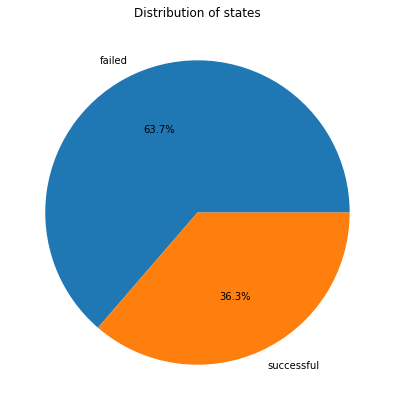

In [35]:
df_state = df[(df["state"] != "undefined")].groupby(["state"])["ID"].nunique()
ax = df_state.plot(kind="pie", figsize=(7,7), autopct="%1.1f%%")
ax.set_title("Distribution of states")
ax.set_ylabel("")

On average, failed and canceled projects tend to ask for a much higher amount of money than successful ones.

Text(0, 0.5, 'Goal (USD)')

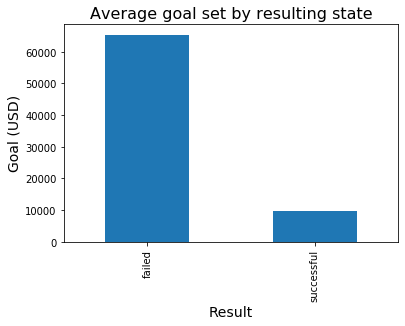

In [36]:
df_goal_state = df.groupby(["state"])["usd_goal_real"].mean()
ax = df_goal_state.plot(kind="bar")
ax.set_title("Average goal set by resulting state", size=16)
ax.set_xlabel("Result", size=14)
ax.set_ylabel("Goal (USD)", size=14)

The bulk of the data has reached 100% of its goal or less. The more successful projects can generate up to 2.5 times the amount they asked for.

There is an non-negligible number of outliers above the upper bound (about 18,000), the best ones having a ridiculously high percentage of success (max = 104,277.89 %). This is typically when the project owner asked only for a low amount of money, like 1 or 10 USD, and then met with tremendous success.

Text(0, 0.5, '% Success')

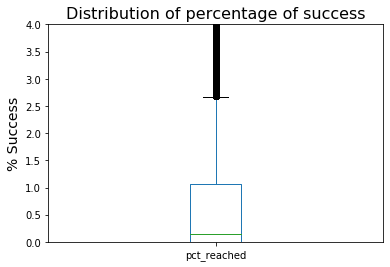

In [37]:
ax = df["pct_reached"].plot(kind="box", ylim=(0,4))
ax.set_title("Distribution of percentage of success", size=16)
ax.set_ylabel("% Success", size=14)

In [38]:
df["pct_reached"].sort_values().tail(10)

164449     16970.86
15288      22603.00
290936     23036.07
369214     24675.00
285408     27588.23
81368      32843.00
76290      41535.01
360721     55266.57
186096     68764.10
369176    104277.89
Name: pct_reached, dtype: float64

In [39]:
df[df["pct_reached"] > 2.7].shape[0]

17496

Close to a third of all projects are either related to the movie or the music industry.

Text(0, 0.5, 'Category')

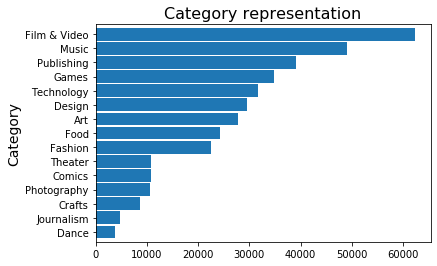

In [40]:
df_main_cat = df.groupby(["main_category"])["ID"].nunique().sort_values(ascending=True)
ax = df_main_cat.plot(kind="barh", x="main_category", width=0.9)
ax.set_title("Category representation", size=16)
ax.set_ylabel("Category", size=14)

In [41]:
print("Percentage of projects in the film and music industries:", (df_main_cat.iloc[-1] + df_main_cat.iloc[-2]) / df.shape[0] * 100)

Percentage of projects in the film and music industries: 30.076252164259532


Non surprisingly, Kickstarter being first and foremost an English-speaking platform, the top 3 most represented countries are the US (by a large margin), the UK and Canada. Then come German and French countries.

Text(0, 0.5, '')

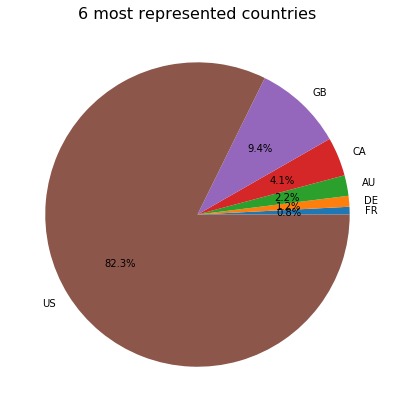

In [42]:
df_country = df.groupby(["country"])["ID"].count().sort_values()
ax = df_country.tail(6).plot(kind="pie", figsize=(7,7), autopct="%1.1f%%")
ax.set_title("6 most represented countries", size=16)
ax.set_ylabel("")

# EDA BACKERS
Analyse des bakers selon plusieurs paramètre:</br>


1.   Quantité de bakers selon les statuts finaux (mean, max, min, median, mode)
2.   Quantité de bakers selon le type de projet (mean, max, min, median, mode)
3.   Quantité de bakers selon le pays (mean, max, min, median, mode)
4.   etc....




## Value of Bakers depending of the final state

as we can see below, the numbers of backers is pretty random and the spread is really big. 
The number of outliers seem to be really big with a mean at 263, a median at 71 and a mode at 19.


In [0]:
df.groupby(['state'])['backers'].agg(['mean','min','max','median',('mode',lambda x: x.mode()[0])])

,mean,min,max,median,mode
state,,,,,
failed,17.514777,0,9326,3,0
successful,263.704277,1,219382,71,19


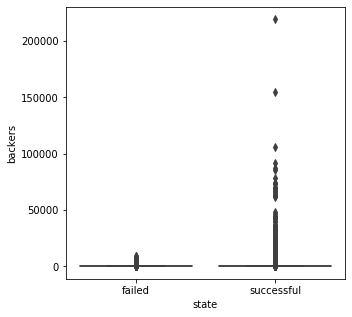

In [0]:
ax = sns.boxplot(x='state', y='backers', data=df)

As we thought the spread is super huge and the number of outliers is super huge too. Then we will represente in the result of the logarithme of those value

## Bakers selon la main_category


In [61]:
df.groupby(['main_category'])['backers'].agg(['mean','min','max','median', ('mode',lambda x: x.mode()[0])])

,mean,min,max,median,mode
main_category,,,,,
Art,42.380267,0,22834,10,0
Comics,135.629198,0,14952,40,0
Crafts,27.629258,0,12705,3,0
Dance,43.097430,0,4133,27,0
Design,241.601762,0,154926,29,0
Fashion,61.903987,0,15129,5,0
Film & Video,67.324706,0,91585,12,0
Food,54.408317,0,13116,6,0
Games,325.606786,0,219382,30,0


##Backer in function of:

the years : here we can see the evolution of number of backer each years.

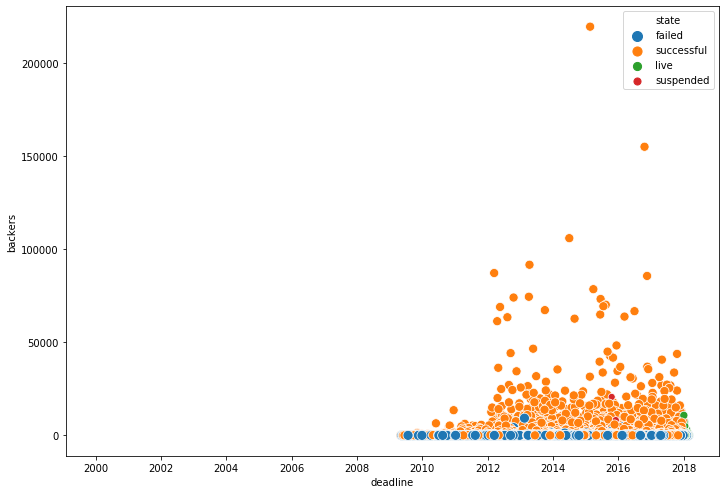

In [0]:
fig, ax= plt.subplots()
fig.set_size_inches(11.7, 8.27)
sns.scatterplot(x="deadline", y="backers", hue='state', size='state', sizes=(50, 100), data=df)

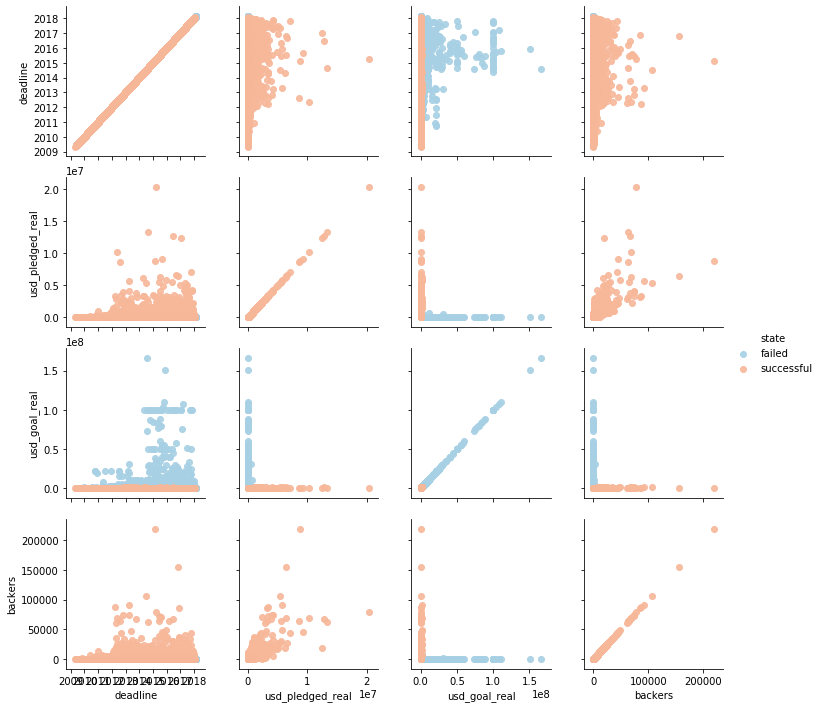

In [62]:
g = sns.PairGrid(df, vars=['deadline', 'usd_pledged_real', 'usd_goal_real', 'backers'],
                 hue='state', palette='RdBu_r')
g.map(plt.scatter, alpha=0.9)
g.add_legend();

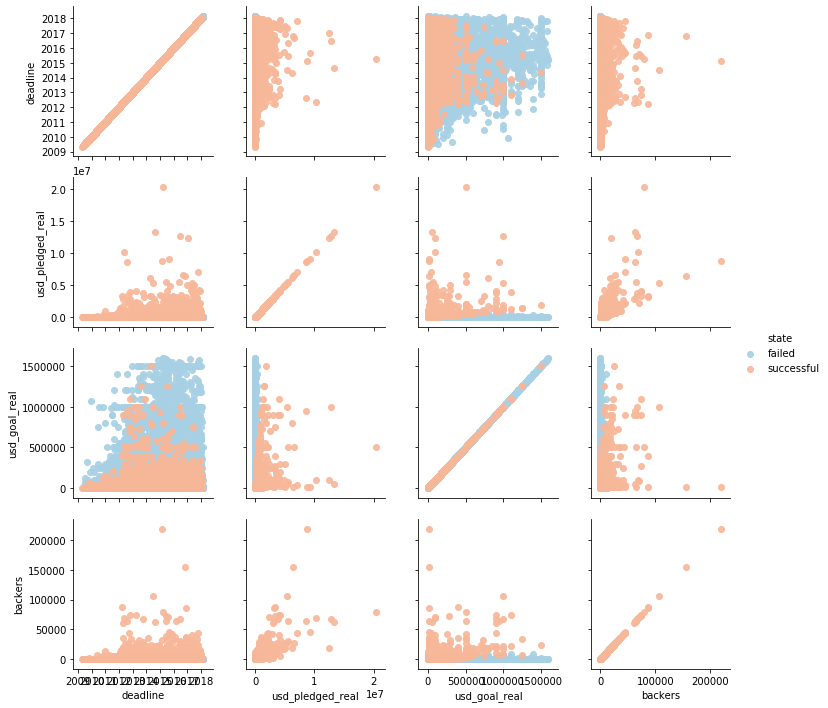

In [63]:
g = sns.PairGrid(df[df["usd_goal_real"]<1600000], vars=['deadline', 'usd_pledged_real', 'usd_goal_real', 'backers'],
                 hue='state', palette='RdBu_r')
g.map(plt.scatter, alpha=0.9)
g.add_legend();

Do you have good chances of running a successful Kickstarter campaign if you're not from the US/CA?

Text(0.5, 0, 'Country')

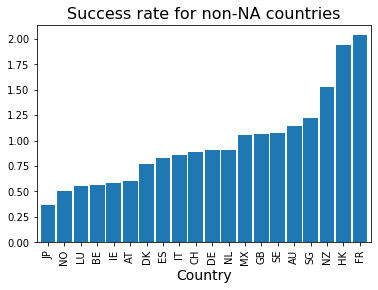

In [0]:
df_without_na = df[(~df["country"].isin(["US", "CA"]))].groupby(["country"])["pct_reached"].mean().sort_values()
df_without_na
ax = df_without_na.plot(kind="bar", width=0.9)
ax.set_title("Success rate for non-NA countries", size=16)
ax.set_xlabel("Country", size=14)

Which categories are the most successful?

Text(0, 0.5, 'Category')

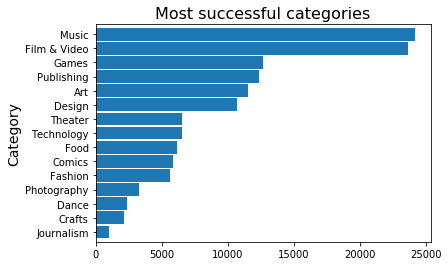

In [0]:
df_success = df[(df["state"] == "successful")].groupby(["main_category"])["ID"].count().sort_values()
ax = df_success.plot(kind="barh", x="main_category", width=0.9)
ax.set_title("Most successful categories", size=16)
ax.set_ylabel("Category", size=14)

How much money is asked for on average by category?

Text(0, 0.5, 'Category')

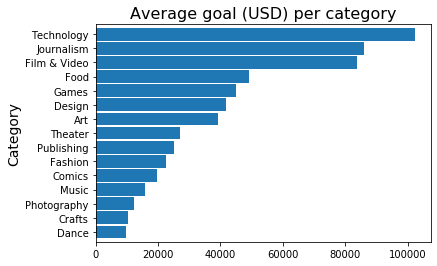

In [0]:
df_avg_goal = df.groupby(["main_category"])["usd_goal_real"].mean().sort_values(ascending=True)
ax = df_avg_goal.plot(kind="barh", width=0.9)
ax.set_title("Average goal (USD) per category", size=16)
ax.set_ylabel("Category", size=14)

Most successful categories in Switzerland? How much money do they ask for on average?

In [0]:
df_switzerland = df[(df["country"] == "CH") & (df["state"] == "successful")].groupby(["main_category"])[["ID", "usd_goal_real"]].agg({"ID":"count", "usd_goal_real":"mean"}).sort_values(by="ID", ascending=False)
df_switzerland.head(5)

,ID,usd_goal_real
main_category,,
Design,53,35231.027925
Technology,37,27529.069730
Fashion,20,18541.223000
Games,18,15451.385556
Art,15,2548.498000


# Machine Learning Models

## Linear Regression

In [43]:
X = df[["usd_goal_real", "usd_pledged_real"]]
y = df["state"]
X.head()

,usd_goal_real,usd_pledged_real
0,1533.95,0.0
1,30000.00,2421.0
2,45000.00,220.0
3,5000.00,1.0
4,19500.00,1283.0


In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [0]:
from sklearn.linear_model import LogisticRegressionCV
LR = LogisticRegressionCV(solver='lbfgs', cv=5, max_iter=1000)

In [46]:
LR.fit(X_train, y_train)

LogisticRegressionCV(Cs=10, class_weight=None, cv=5, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=1000, multi_class='warn', n_jobs=None,
                     penalty='l2', random_state=None, refit=True, scoring=None,
                     solver='lbfgs', tol=0.0001, verbose=0)

No surprise there. Based on the goal set and the amount pledged, the prediction 

*   Élément de liste
*   Élément de liste

of whether the project failed or succeeded is obvious.

In [47]:
LR.score(X_test, y_test)

0.9984198584625358

In [0]:
from sklearn.preprocessing import OneHotEncoder
one_hot = OneHotEncoder(categories="auto")
cat_to_onehot = one_hot.fit_transform(df[["main_category", "country"]]).toarray()
X = pd.DataFrame(cat_to_onehot)

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
LR.fit(X_train, y_train)
LR.score(X_test, y_test)

0.6490600183674572

## Classifier KNN

In [0]:
from sklearn.neighbors import KNeighborsClassifier
scores = []
kMax=0
for k in range(1, 100, 1):
    clf = KNeighborsClassifier(n_neighbors=k)
    clf.fit(X_train, y_train)
    scores.append(clf.score(X_test, y_test))
    if clf.score(X_test, y_test) >= max(scores):
      kMax = k
plt.plot(range(1, 100, 1), scores)
plt.ylabel('accuracy', fontsize=15)
plt.xlabel('$k (knn2)$', fontsize=15)
print("kMax: ",kMax)

## Neural Network

In [15]:
!pip install --upgrade tensorflow==1.14.0

     |████████████████████████████████| 109.2MB 43kB/s 
     |████████████████████████████████| 491kB 52.0MB/s 
     |████████████████████████████████| 3.2MB 32.8MB/s 
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
  Found existing installation: tensorflow 1.15.0
    Uninstalling tensorflow-1.15.0:
      Successfully uninstalled tensorflow-1.15.0


In [16]:
!pip install keras

In [17]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (5,5) # Make the figures a bit bigger
from sklearn.datasets import load_digits
from keras.utils import np_utils

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

We use the same split used in the regression

In [18]:
df["state"].unique()

array(['failed', 'canceled', 'successful', 'live', 'undefined',
       'suspended'], dtype=object)

In [19]:
df['state'] = df['state'].map({'successful': 1, 'failed': 0})
df["state"].unique()

array([ 0., nan,  1.])

Modifing the Target

In [0]:
y1 = df["state"]

In [21]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y1, test_size=0.2)
#convert target labels to one-hot vectors, this is required if we want to use categorical cross-entropy
Y_train = np_utils.to_categorical(Y_train, 2) #two classes -> successful or failed
Y_test = np_utils.to_categorical(Y_test, 2)   

IndexError: ignored

In [0]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras import optimizers
np.random.seed(1125)

(296175, 37, 2)

In [0]:
model = Sequential() #you start with this to say it's a multiple layer model
model.add(Dense(512, input_shape=(37, 2))) #37 colonne et 2 possibilités qui correspondent à la forme de la matrice
model.add(Activation('relu')) # An "activation" is just a non-linear function applied to the output
                              # of the layer above. Here, with a "rectified linear unit",
                              # we clamp all values below 0 to 0.
                           
model.add(Dropout(0.2))   # Dropout helps protect the model from memorizing or "overfitting" the training data
model.add(Dense(10))
model.add(Activation('softmax')) # This special "softmax" activation among other things,
                                 # ensures the output is a valid probaility distribution, that is
                                 # that its values are all non-negative and sum to 1.

In [0]:
# model summary
model.summary() #it show you the layer in the network and the number of parametter

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 37, 512)           1536      
_________________________________________________________________
activation_19 (Activation)   (None, 37, 512)           0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 37, 512)           0         
_________________________________________________________________
dense_20 (Dense)             (None, 37, 10)            5130      
_________________________________________________________________
activation_20 (Activation)   (None, 37, 10)            0         
Total params: 6,666
Trainable params: 6,666
Non-trainable params: 0
_________________________________________________________________


In [0]:
optimizer = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True) #SGD est le nom de l'optimizer lr = learning rate, decay = taille des smallers steps
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy']) #la Loss fonction utilisée, l'optimizer et le metrics que l'on verifie

In [0]:
model_hist = model.fit(X_train1, Y_train, #la validation est effectué à chaque epoch
                       batch_size=64, epochs=20, #epochs= on va passer 20 fois dans tout le dataset
                       verbose=1, validation_split=0.2) #verbose= 

ValueError: ignored

In [0]:
print(Y_train.shape)

(296175, 2)


In [0]:
from keras.utils import to_categorical
X_train1 = to_categorical(X_train)

In [7]:
print(X_train1.shape)

NameError: ignored